# Counterfactual Transportability

This notebook is a demonstration of algorithms from Correa, Lee, and Bareinboim's 2022 paper, [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf).

In [6]:
import os
import sys

if "[redacted]/y0/src/" not in sys.path:
    sys.path.append("[redacted]/y0/src/")

In [44]:
import logging
import unittest
from collections import defaultdict

from networkx import NetworkXError

#from tests.test_algorithm import cases
from y0.algorithm.counterfactual_transportability import (
    _any_inconsistent_intervention_values,
    _any_variable_values_inconsistent_with_interventions,
    _any_variables_with_inconsistent_values,
    _compute_ancestral_components_from_ancestral_sets,
    _counterfactual_factor_is_inconsistent,
    _get_ancestral_components,
    _get_ancestral_set_after_intervening_on_conditioned_variables,
    _get_conditioned_variables_in_ancestral_set,
    _initialize_conditional_transportability_data_structures,
    _no_intervention_variables_in_domain,
    _no_transportability_nodes_in_domain,
    _reduce_reflexive_counterfactual_variables_to_interventions,
    _remove_repeated_variables_and_values,
    _remove_transportability_vertices,
    _split_event_by_reflexivity,
    _transport_conditional_counterfactual_query_line_2,
    _transport_conditional_counterfactual_query_line_4,
    _transport_unconditional_counterfactual_query_line_2,
    _valid_topo_list,
    _validate_transport_conditional_counterfactual_query_input,
    _validate_transport_conditional_counterfactual_query_line_4_output,
    convert_to_counterfactual_factor_form,
    counterfactual_factors_are_transportable,
    do_counterfactual_factor_factorization,
    get_ancestors_of_counterfactual,
    get_counterfactual_factors,
    is_counterfactual_factor_form,
    make_selection_diagrams,
    minimize,
    minimize_event,
    same_district,
    simplify,
    transport_conditional_counterfactual_query,
    transport_district_intervening_on_parents,
    transport_unconditional_counterfactual_query,
)
from y0.algorithm.transport import transport_variable
from y0.dsl import (
    PP,
    TARGET_DOMAIN,
    W1,
    W2,
    W3,
    W4,
    W5,
    X1,
    X2,
    CounterfactualVariable,
    Fraction,
    Intervention,
    One,
    P,
    Pi1,
    Pi2,
    Product,
    R,
    Sum,
    Variable,
    W,
    X,
    Y,
    Z,
    Zero,
)
from y0.graph import NxMixedGraph
from y0.algorithm.identify import identify_outcomes

## Conditional transportability example: education and well-being

Suppose we're interested in the effect of a college degree on overall well-being, net of income. We might imagine a graph like the following:



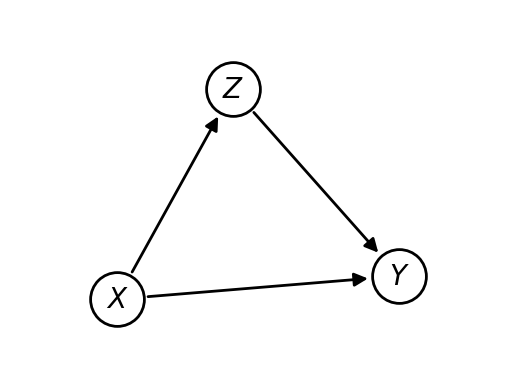

In [35]:
simple_education_graph = NxMixedGraph.from_edges(
    directed=[
        (X, Z),
        (Z, Y),
        (X, Y),
    ],
    undirected=[],
)
simple_education_graph.draw()

Here, X represents education, Z represents income, and Y represents well-being. Thanks to an implementation of Shpitser's ID algorithm in Y0 by Nathaniel Merrill, we can estimate the effect of education on income:

In [45]:
identify_outcomes(simple_education_graph, treatments={X}, outcomes={Y})

Sum[Z](P(Y | X, Z) * P(Z | X))

This model is of course too simplistic, because many factors affect both education and income such as self-control, parental education, high school GPA, and so on. Let's represent those factors, "confounders", by a bi-directed edge between X and Z:

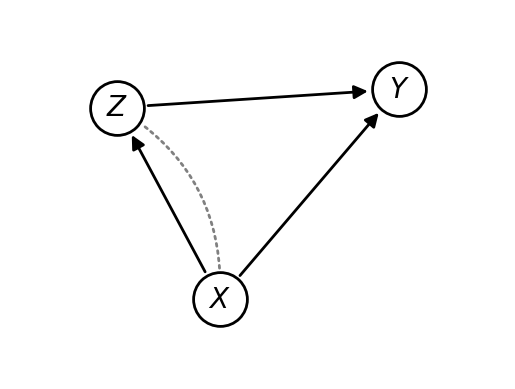

In [42]:
figure_1_graph = NxMixedGraph.from_edges(
    directed=[
        (X, Z),
        (Z, Y),
        (X, Y),
    ],
    undirected=[(Z, X)],
)
figure_1_graph.draw()

The effect of education on income is not identifiable due to the confounders:

In [49]:
identify_outcomes(figure_1_graph, treatments={X}, outcomes={Y})==None

True

Suppose we want to know the effect of a college major $x$ on a person's overall happiness net of their income, were they forced to major in $x$ instead of the major they actually wanted, $x'$. That would be represented in `Y0`as follows:

In [60]:
target = PP[TARGET_DOMAIN](Y@-X | Z@-X, +X)
display(target)

P(Y @ -X | +X, Z @ -X)

Next, let's consider that we have two populations: an observational study in the United States, and an experiment in Australia in which students were randomly assigned to college majors and the effect on income was observed (in practice a randomized controlled trial with a treatment variable such as college major is infeasible, but it can be approximated through longitudinal studies and techniques such as inverse probability weighting). Moreover, suppose the distribution of well-being in Australia is different than in the United States.

In [50]:
# [correa22a]_, Figure 1, without the transportability node.
# (This graph represents the target domain, the United States.)
figure_1_graph_no_transportability_nodes = NxMixedGraph.from_edges(
    directed=[
        (X, Z),
        (Z, Y),
        (X, Y),
    ],
    undirected=[(Z, X)],
)


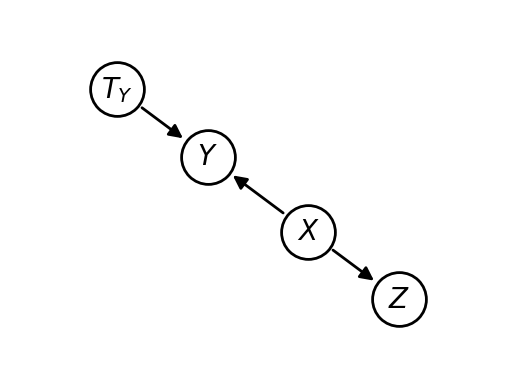

In [56]:
# Here is Australia.
figure_1_graph_domain_1_with_interventions = NxMixedGraph.from_edges(
    directed=[(X, Z), (X, Y), (transport_variable(Y), Y)],
    undirected=[],
)
figure_1_graph_domain_1_with_interventions.draw()

The transportability node in the graph is there to remind us that the difference in the populations prohibits us from directly running the Identify algorithm on the graph for the Australian population to estimate the effect of education on well-being for the American sample.

SyntaxError: unterminated string literal (detected at line 1) (463160959.py, line 1)

We can estimate the effect using the conditional counterfactual transportability algorithm in `Y0`:

In [64]:
example_1_outcomes = [(Y @ -X, -Y)]
example_1_conditions = [(Z @ -X, -Z), (X, +X)]
example_1_target_domain_graph = figure_1_graph_no_transportability_nodes

figure_1_graph_no_transportability_nodes_topo = list(
    figure_1_graph_no_transportability_nodes.topological_sort()
) # Topologically sorted list of the vertices in the United States graph
figure_1_graph_domain_1_with_interventions_topo = list(
    figure_1_graph_domain_1_with_interventions.topological_sort()
) # Topologically sorted list of the vertices in the Australia graph
example_1_domain_graphs = [
    (
        figure_1_graph_no_transportability_nodes,
        figure_1_graph_no_transportability_nodes_topo,
    ), # United States
    (
        figure_1_graph_domain_1_with_interventions,
        figure_1_graph_domain_1_with_interventions_topo,
    ), # Australia
]
domain_data = [(set(), PP[TARGET_DOMAIN](X, Y, Z)), # United States
               ({X}, PP[Pi1](X, Y, Z))] # Australia
#expected_result_expr, expected_result_event = (
#    Fraction(PP[TARGET_DOMAIN](Y | X, Z), Sum.safe(PP[TARGET_DOMAIN](Y | X, Z), {Y})),
#    [(Y, -Y), (X, +X), (Z, -Z)],
#)
result_expr, result_event = transport_conditional_counterfactual_query(
    outcomes=example_1_outcomes,
    conditions=example_1_conditions,
    target_domain_graph=example_1_target_domain_graph,
    domain_graphs=example_1_domain_graphs,
    domain_data=domain_data,
)
print(str(result_event))
display(result_expr)

Initialization complete.
vertex_to_ancestral_set_mappings: defaultdict(<class 'set'>, {Y: {frozenset({Y @ -X})}, X: {frozenset({X})}, Z: {frozenset({Z @ -X})}})
original_to_merged_ancestral_set_mappings: {frozenset({Y @ -X}): frozenset({Y @ -X}), frozenset({X}): frozenset({X}), frozenset({Z @ -X}): frozenset({Z @ -X})}
Ancestral components: {frozenset({Y @ -X}), frozenset({X}), frozenset({Z @ -X})}
Considering variable Y(base variable Y) at start of vertex loop.
   visited_vertices: set()
Considering variable X(base variable X) at start of vertex loop.
   visited_vertices: {Y}
Considering variable Z(base variable Z) at start of vertex loop.
   visited_vertices: {Y, X}
Finished pass through the vertices.
vertex_to_ancestral_set_mappings: defaultdict(<class 'set'>, {Y: {frozenset({Y @ -X})}, X: {frozenset({X})}, Z: {frozenset({Z @ -X})}})
original_to_merged_ancestral_set_mappings: {frozenset({Y @ -X}): frozenset({Y @ -X}), frozenset({X}): frozenset({X}), frozenset({Z @ -X}): frozenset({Z

[(Y, -Y), (Z, -Z), (X, +X)]


((P(Y | X, Z) / Sum[Y](P(Y | X, Z))))

For this example, it turns out that we can just compute the probability of well-being given education and income for the United States, and we actually don't need the Australian data. That can happen. Note that Correa, Lee, and Bareinboim have an algorithm for _conditional transportability_ and an algorithm for _unconditional transportability_. Example 1 is in their paper to demonstrate that in some cases, conditional transportability works when unconditional transportability does not:

In [71]:
event=[(Y @ -X, -Y), (Z @ -X, -Z), (X, +X)]
transport_unconditional_counterfactual_query(
    event=event,
    target_domain_graph=example_1_target_domain_graph,
    domain_graphs=example_1_domain_graphs,
    domain_data=domain_data,
)==None

In simplify before return: return value = [(Y @ -X, -Y), (Z @ -X, -Z), (X, +X)]
In get_counterfactual_factors_retaining_variable_values(): district_mappings = defaultdict(<class 'set'>, {frozenset({X, Z}): {(X, +X), (Z @ -X, -Z)}, frozenset({Y}): {(Y @ (-X, -Z), -Y)}})
In get_counterfactual_factors_retaining_variable_values(): returning [{(X, +X), (Z @ -X, -Z)}, {(Y @ (-X, -Z), -Y)}]
In _any_variable_values_inconsistent_with_interventions: dictionary = defaultdict(<class 'set'>, {X: {+X, -X}})
In transport_unconditional_counterfactual_query: inconsistent counterfactual factor. Returning FAIL (None)


True

The reason turns out to be that $Z_{x}$ and $x'$ are in the same c-component (they're connected by bi-directed edges). The problem is that we're considering the value of $Z$ in a world where $X$ has been forced to be $x$, while simultaneously considering $X$ having a value of $x'$. Because $Z$ and $X$ are connected by a path consisting of bi-directed edges, to transport the unconditional query $P(Y_x, Z_x, x')$ we would have to be able to identify the probabilistic expression associated with the c-component ${X,Z}$, but cannot because of the inconsistent values of $X$.

## Unconditional transportability example: education and earnings

Suppose we're interested in the effect of a college degree ($X$) on earnings ($Y$), in a model where family socioeconomic status ($Z$) affects earnings and selection into the type of college degree, while also being confounded with college degree. Additionally, the college degree affects occupation ($W$), which affects earnings and is also confounded with earnings. Here's the graph:

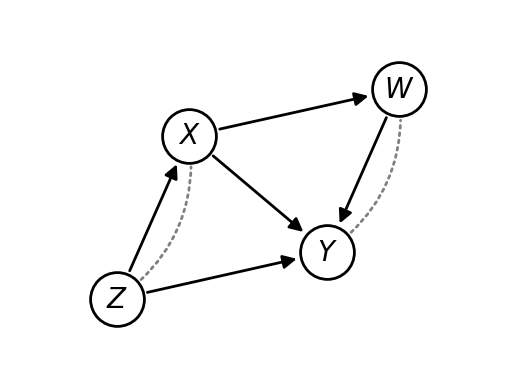

In [99]:
figure_2a_graph = NxMixedGraph.from_edges(
    directed=[
        (Z, X),
        (Z, Y),
        (X, Y),
        (X, W),
        (W, Y),
    ],
    undirected=[(Z, X), (W, Y)],
)
figure_2a_graph.draw()

Suppose we want to know what studying computer science ($x_0$) does to earnings in a target population $\pi^\ast$, but specifically for people who choose to study computer science. So, we care about the difference between the earnings for people who choose to study computer science, compared to those for the average person forced to study it. Thus, we wish to know $E[Y_{x_0} | x_0] - \Sigma_{x}{\alpha_{x}E[Y_x | x_0]}$. For the first quantity, this is $E[Y | x_0]$. For the second quantity, $\alpha_{x}$ is just a weight that could be the proportion of various majors in the population, and we'll ignore that for the transportability problem and just focus on estimating $E[Y_x | x_0]$, which is $E[Y_x, x_0] / E[x_0]$. Let's estimate $E[Y_x, x_0]$ using `transport_unconditional_counterfactual_query()`, introducing our data sets first.

### Data

Here we imagine we have a study in which students were given scholarships to pursue any degree they wanted regardless of their family income, removing the bi-directed edge between $Z$ and $X$ (Domain 1). But that population, $\pi^1$, has a different distribution of income than our population of interest:


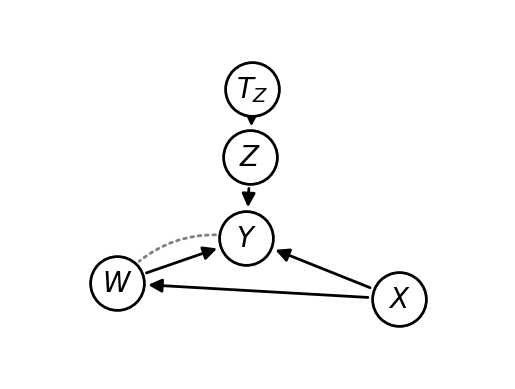

In [113]:
figure_2_graph_domain_1_with_interventions = NxMixedGraph.from_edges(
    directed=[(X, Y), (X, W), (W, Y), (Z, Y), (transport_variable(Z), Z)],
    undirected=[
        (W, Y),
    ],
)
figure_2_graph_domain_1_with_interventions_topo = list(
    figure_2_graph_domain_1_with_interventions.topological_sort()
)
figure_2_graph_domain_1_with_interventions.draw()

The second set of data is an observational study in a second population, $\pi^2$, for which the distribution of occupations is also different than the target population $\pi^{\ast}$:

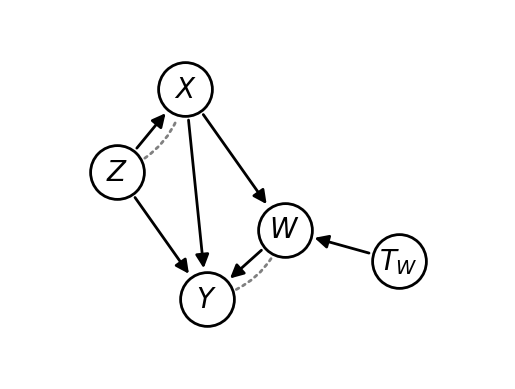

In [115]:
# From [correa22a]_, Figure 3b.
figure_2_graph_domain_2 = NxMixedGraph.from_edges(
    directed=[
        (Z, X),
        (Z, Y),
        (X, Y),
        (X, W),
        (W, Y),
        (transport_variable(W), W),
    ],
    undirected=[(Z, X), (W, Y)],
)
figure_2_graph_domain_2_topo = list(figure_2_graph_domain_2.topological_sort())
figure_2_graph_domain_2.draw()

Let's estimate $E[Y_x, x_0]$:

In [107]:
example_2_event = [(Y @ -X, -Y), (X, -X)]
example_2_domain_graphs = [
    (
        figure_2_graph_domain_1_with_interventions,
        figure_2_graph_domain_1_with_interventions_topo,
    ),
    (
        figure_2_graph_domain_2,
        figure_2_graph_domain_2_topo,
    ),
]
example_2_domain_data = [({X}, PP[Pi1](W, X, Y, Z)), (set(), PP[Pi2](W, X, Y, Z))]
expected_result_part_1 = Product.safe(
    [PP[Pi1](Y | W, X, Z), PP[Pi1](W | X), PP[Pi2](X | Z), PP[Pi2](Z)]
)
expected_result = Sum.safe(expected_result_part_1, [Z, W])

example_2_result_expr, example_2_result_event = transport_unconditional_counterfactual_query(
    event=example_2_event,
    target_domain_graph=figure_2a_graph,
    domain_graphs=example_2_domain_graphs,
    domain_data=example_2_domain_data,
)

In simplify before return: return value = [(Y @ -X, -Y), (X, -X)]
In get_counterfactual_factors_retaining_variable_values(): district_mappings = defaultdict(<class 'set'>, {frozenset({X, Z}): {(Z, None), (X @ -Z, -X)}, frozenset({Y, W}): {(Y @ (-W, -X, -Z), -Y), (W @ -X, None)}})
In get_counterfactual_factors_retaining_variable_values(): returning [{(Z, None), (X @ -Z, -X)}, {(Y @ (-W, -X, -Z), -Y), (W @ -X, None)}]
In _any_variable_values_inconsistent_with_interventions: dictionary = defaultdict(<class 'set'>, {Z: {-Z}})
In _any_inconsistent_intervention_values: dictionary = defaultdict(<class 'set'>, {Z: {-Z}})
In _any_variable_values_inconsistent_with_interventions: dictionary = defaultdict(<class 'set'>, {W: {-W}})
In _any_inconsistent_intervention_values: dictionary = defaultdict(<class 'set'>, {Z: {-Z}, X: {-X}, W: {-W}})
k = 0
k = 1
In identify_district_variables: A = C. Applying Lemma 3.
   Subgraph_probability = P^{π_2}(X | Z) P^{π_2}(Z)
   Returning Q value: P^{π_2}(X | Z) P^

In [108]:
print(str(example_2_result_event))
display(example_2_result_expr)

[(Y @ -X, -Y), (X, -X)]


Sum[W, Z](P(W | X) * P(Y | X, W, Z) * P(X | Z) * P(Z))

Here we can see the results from the two domain populations getting combined to resolve a causal query for the target population! That result matches Equation 4 in Correa, Lee, and Bareinboim net of some simplification. Next, here's $E[Y, x0]$:

In [116]:
example_2_event_2 = [(Y, -Y), (X, -X)]
example_2_result_expr_2, example_2_result_event_2 = transport_unconditional_counterfactual_query(
    event=example_2_event_2,
    target_domain_graph=figure_2a_graph,
    domain_graphs=example_2_domain_graphs,
    domain_data=example_2_domain_data,
)

In simplify before return: return value = [(Y, -Y), (X, -X)]
In get_counterfactual_factors_retaining_variable_values(): district_mappings = defaultdict(<class 'set'>, {frozenset({Y, W}): {(Y @ (-W, -X, -Z), -Y), (W @ -X, None)}, frozenset({X, Z}): {(Z, None), (X @ -Z, -X)}})
In get_counterfactual_factors_retaining_variable_values(): returning [{(Y @ (-W, -X, -Z), -Y), (W @ -X, None)}, {(Z, None), (X @ -Z, -X)}]
In _any_variable_values_inconsistent_with_interventions: dictionary = defaultdict(<class 'set'>, {W: {-W}})
In _any_inconsistent_intervention_values: dictionary = defaultdict(<class 'set'>, {Z: {-Z}, X: {-X}, W: {-W}})
In _any_variable_values_inconsistent_with_interventions: dictionary = defaultdict(<class 'set'>, {Z: {-Z}})
In _any_inconsistent_intervention_values: dictionary = defaultdict(<class 'set'>, {Z: {-Z}})
k = 0
k = 1
In identify_district_variables: A = C. Applying Lemma 3.
   Subgraph_probability = P^{π_1}(W | X) P^{π_1}(Y | X, W, Z)
   Returning Q value: P^{π_1}(W | 

In [117]:
print(str(example_2_result_event_2))
display(example_2_result_expr_2)

[(Y, -Y), (X, -X)]


Sum[W, Z](P(W | X) * P(Y | X, W, Z) * P(X | Z) * P(Z))

In [ ]:
Compare this result to Equation 5 in Correa, Lee, and Bareinboim. Combining these two results, we can estimate our causal effect of interest.

It's worth noting we can also use `transport_conditional_counterfactual_query()` to estimate $P(Y_x | x_0)$. The result is messier, but simplifying it and multiplying by $P(x_0)$ gives us the unconditional query result:

In [118]:
result_expr, result_event = transport_conditional_counterfactual_query(
    outcomes=[(Y@-X,-Y)],
    conditions=[(X,-X)],
    target_domain_graph=figure_2a_graph,
    domain_graphs=example_2_domain_graphs,
    domain_data=example_2_domain_data,
)

Initialization complete.
vertex_to_ancestral_set_mappings: defaultdict(<class 'set'>, {X: {frozenset({X, Z})}, Z: {frozenset({X, Z}), frozenset({Y @ -X, W @ -X, Z})}, Y: {frozenset({Y @ -X, W @ -X, Z})}, W: {frozenset({Y @ -X, W @ -X, Z})}})
original_to_merged_ancestral_set_mappings: {frozenset({X, Z}): frozenset({X, Z}), frozenset({Y @ -X, W @ -X, Z}): frozenset({Y @ -X, W @ -X, Z})}
Ancestral components: {frozenset({X, Z}), frozenset({Y @ -X, W @ -X, Z})}
Considering variable X(base variable X) at start of vertex loop.
   visited_vertices: set()
Considering variable Z(base variable Z) at start of vertex loop.
   visited_vertices: {X}
Combining frozen sets for vertex Z.
   vertex_to_ancestral_set_mappings[v]: {frozenset({X, Z}), frozenset({Y @ -X, W @ -X, Z})}
   Just updated s_new to {X, Y @ -X, W @ -X, Z}
   s_new_frozen = frozenset({X, Y @ -X, W @ -X, Z})
   Ancestral components prior to update: {frozenset({X, Z}), frozenset({Y @ -X, W @ -X, Z})}
   updated original_to_merged_ances

In [110]:
print(str(result_event))
display(result_expr)

[(Y, -Y), (X, -X)]


((Sum[W, Z](P(W | X) * P(Y | X, W, Z) * P(X | Z) * P(Z)) / Sum[W, Y, Z](P(W | X) * P(Y | X, W, Z) * P(X | Z) * P(Z))))